## **Exploración del precio histórico del cacao:** AgroNet
**Hecho por:** Pedro Sánchez - 202215902
### Importación de librerias y datos
Primero, es necesario importar las librerias que usaremos, así como importar los datos y revisar que sean los que necesitamos.

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_excel("AgroNet.xlsx")

### Revisar primeras y ultimas filas
Esta operación nos muestra una vista rápida del inicio y fin del DataFrame. Nos permite detectar rápidamente inconsistencias, valores extraños o errores en la importación.

In [3]:
df.head()   # primeras 5 filas

,Producto,Fecha,Valor,Unidad
0,Cacao Nacional,2013-07-01,3762.5,CO$/KG
1,Cacao Nacional,2013-07-08,3797.5,CO$/KG
2,Cacao Nacional,2013-07-15,3737.5,CO$/KG
3,Cacao Nacional,2013-07-22,3797.5,CO$/KG
4,Cacao Nacional,2013-07-29,3937.5,CO$/KG


In [4]:
df.tail()   # últimas 5 filas

,Producto,Fecha,Valor,Unidad
616,Cacao Nacional,2025-07-07,25977.5,CO$/KG
617,Cacao Nacional,2025-07-14,25323.0,CO$/KG
618,Cacao Nacional,2025-07-28,23747.0,CO$/KG
619,Cacao Nacional,2025-08-04,24127.2,CO$/KG
620,Cacao Nacional,2025-08-11,24793.8,CO$/KG


### Eliminar columnas irrelevantes
Esta operación elimina columnas que no aporta valor al análisis, esto con el fin de reducir el ruido y mejorar la eficiencia del procesamiento de los datos.

In [5]:
df = df.drop(columns=['Producto',  'Unidad'])
df.head()   # Verificamos que la columna se ha eliminado

,Fecha,Valor
0,2013-07-01,3762.5
1,2013-07-08,3797.5
2,2013-07-15,3737.5
3,2013-07-22,3797.5
4,2013-07-29,3937.5


### Cambio de tipo de datos
Dado que los datos están en formato de texto, esta operación convierte la columna al tipo de dato necesario, garantizando que los calculos y operaciones se hagan correctamente.

In [6]:
df['Valor'] = df['Valor'].astype(float)
df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True)
df.head()   # Verificamos el cambio de tipo de dato

,Fecha,Valor
0,2013-07-01,3762.5
1,2013-07-08,3797.5
2,2013-07-15,3737.5
3,2013-07-22,3797.5
4,2013-07-29,3937.5


### Renombrar columnas
Esta operación cambia el nombre de la columna que le indiquemos. Esto nos ayuda para establecer nombre claros, consistentes y sin espacios (para facilitar el manejo y evitar errores en el código) cuando sea necesario.

In [7]:
df.rename(columns={'Valor': 'COP/kg'}, inplace=True)
df.head()   # Verificamos el cambio de nombre

,Fecha,COP/kg
0,2013-07-01,3762.5
1,2013-07-08,3797.5
2,2013-07-15,3737.5
3,2013-07-22,3797.5
4,2013-07-29,3937.5


### Revisar estadisticas descriptivas
Esta operación calcula métricas básicas (como media, desviación estándar, minimo, máximo, cuartiles) para las columnas que son numéricas. Esto nos ayuda a detectar outliers o valores fuera de rango y entender la distribución inicial de estos datos.

In [8]:
df.describe()

,Fecha,COP/kg
count,621,621.000000
mean,2019-07-06 20:42:53.913043456,9953.588164
min,2013-07-01 00:00:00,3737.500000
25%,2016-07-04 00:00:00,5932.500000
50%,2019-07-07 00:00:00,7725.000000
75%,2022-06-27 00:00:00,8786.700000
max,2025-08-11 00:00:00,36444.700000
std,NaN,7376.409932


### **Gráficos relevantes**


In [9]:
import matplotlib.pyplot as plt

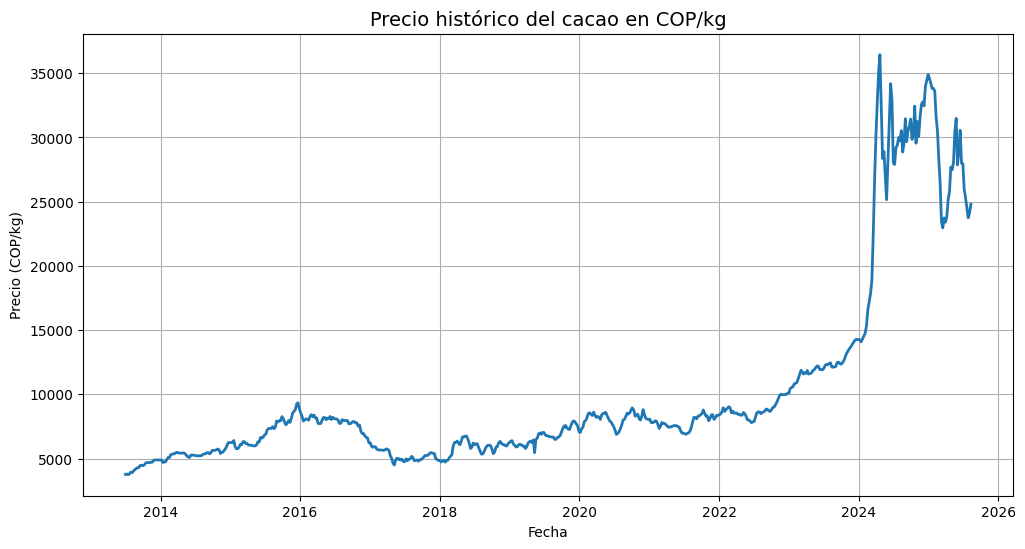

In [10]:
plt.figure(figsize=(12,6))
plt.plot(df["Fecha"], df["COP/kg"], linewidth=2)

plt.title("Precio histórico del cacao en COP/kg", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Precio (COP/kg)")
plt.grid(True)

plt.show()

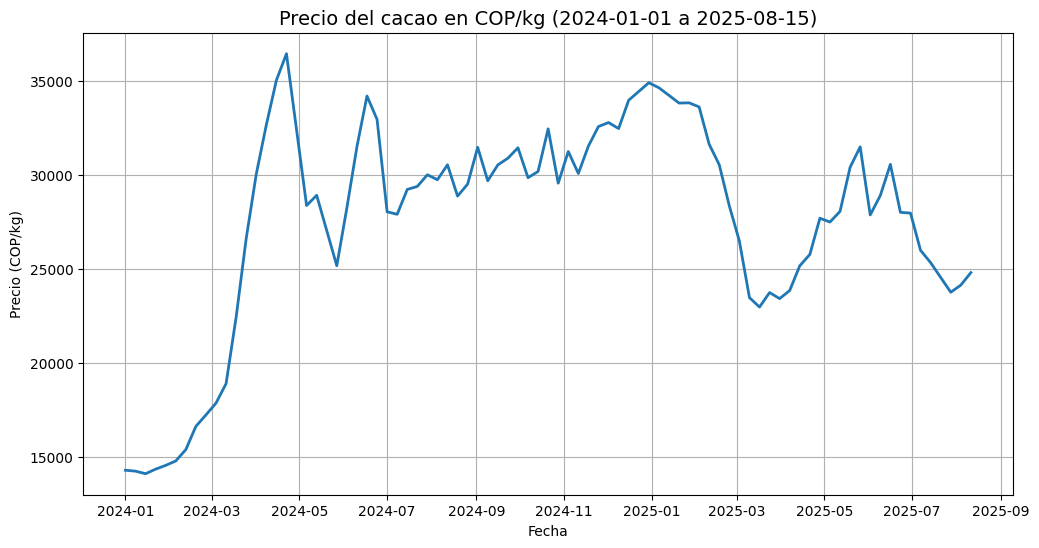

In [20]:
# También se puede definir un rango de fechas especifico
inicio = "2024-01-01"
fin = "2025-08-15"

df_rango = df[(df["Fecha"] >= inicio) & (df["Fecha"] <= fin)]

plt.figure(figsize=(12,6))
plt.plot(df_rango["Fecha"], df_rango["COP/kg"], linewidth=2)

plt.title(f"Precio del cacao en COP/kg ({inicio} a {fin})", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Precio (COP/kg)")
plt.grid(True)
plt.show()

#df_rango.to_excel("DatosAgroNet_limpio.xlsx", index=False) 

### **Descomposición de la serie**
Revisión de tendencia, estacionalidad y residuo ("ruido").

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss

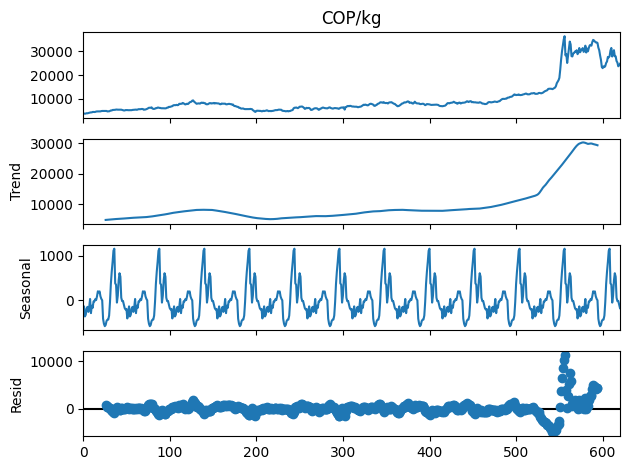

In [13]:
result = seasonal_decompose(df['COP/kg'], model='additive', period=52)
result.plot()
plt.show()

**Tendencia (Trend):** clarísima subida en los últimos periodos (aprox. después de la semana ~500). Eso refleja el boom reciente del precio del cacao en Colombia.

**Estacionalidad (Seasonal):** se ve un patrón que se repite cada año. O sea, sí hay un efecto estacional marcado.

**Residuales (Resid):** los residuos aún tienen bastante variabilidad, sobre todo en el último tramo, pero no es ruido puro todavía.

En resumen: la serie no es estacionaria porque tiene tendencia y estacionalidad.

### **Test de estacionariedad**
En series de tiempo necesitamos saber si los datos son **estacionarios**, es decir, si sus propiedades estadísticas (media, varianza, autocorrelación) no cambian en el tiempo. Para comprobarlo usamos dos pruebas complementarias: el ADF (Augmented Dickey-Fuller) y el KPSS (Kwiatkowski-Phillips-Schmidt-Shin). 

El **ADF** parte de la hipótesis de que la serie sí tiene raíz unitaria (no es estacionaria), por lo que si su p-valor es pequeño (ej. <0.05) rechazamos esa hipótesis y concluimos que la serie es estacionaria. 

En contraste, el **KPSS** asume lo contrario: que la serie sí es estacionaria, por lo que si su p-valor es pequeño (<0.05) rechazamos la estacionariedad. 

Usar ambos es útil porque se complementan: si ADF dice “no estacionaria” y KPSS también, confirmamos el diagnóstico; si dan resultados opuestos, la serie puede necesitar transformaciones (como diferenciación o quitar tendencia/estacionalidad) para volverse estacionaria y ser modelada.

In [14]:
# Dickey-Fuller Aumentado
adf_test = adfuller(df['COP/kg'])
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])

# KPSS
kpss_test = kpss(df['COP/kg'], regression='c')
print('KPSS Statistic:', kpss_test[0])
print('p-value:', kpss_test[1])

ADF Statistic: -0.2738018513037641
p-value: 0.929133690485689
KPSS Statistic: 1.9969781387316157
p-value: 0.01


C:\Users\peter\AppData\Local\Temp\ipykernel_2052\2249114937.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(df['COP/kg'], regression='c')


### **Autocorrelación**
### ACF (Autocorrelación):
Mide la correlación de la serie con sus propios rezagos.

**Ejemplo:** precio hoy vs. precio hace 1 semana, hace 2 semanas, etc.

Si decae lento, significa que la serie todavía tiene dependencia fuerte en el tiempo, es decir, no es estacionaria.

### PACF (Autocorrelación Parcial):

Mide la correlación “pura” con un rezago, eliminando el efecto de los rezagos intermedios.

**Ejemplo:** correlación de la semana actual con la de hace 2 semanas, pero quitando la influencia de la de hace 1 semana.

Sirve para identificar el orden de la parte AR(p) en un modelo. En este caso: los picos grandes en los rezagos 1 y 2 sugieren un modelo AR(1) o AR(2) cuando la serie esté estacionaria.

En resumen:

ACF = qué tan dependiente es la serie de su pasado en general.

PACF = cuáles rezagos específicos importan realmente.

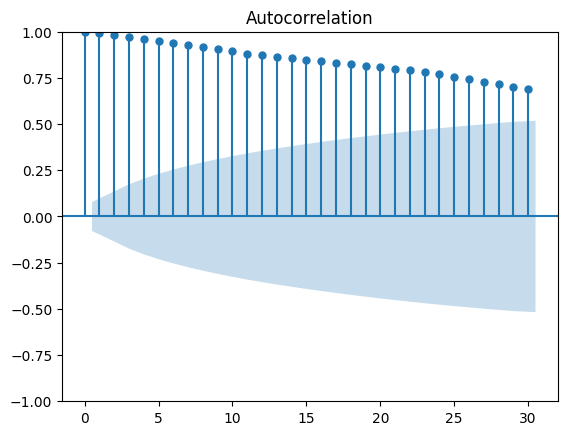

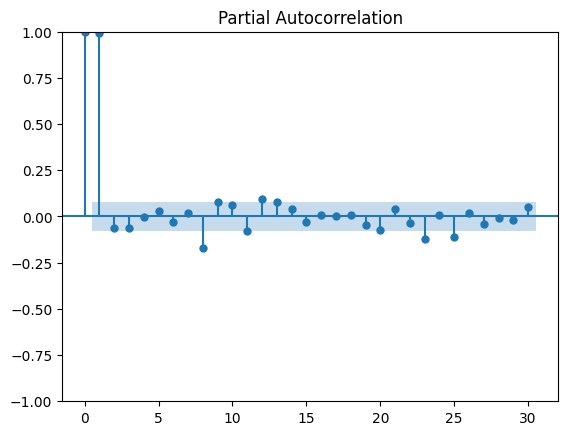

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['COP/kg'], lags=30)
plot_pacf(df['COP/kg'], lags=30)
plt.show()